In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import geopandas as gpd
import geobr
import glob
from matplotlib.colors import ListedColormap


In [2]:
# o banco de dados possui ';' como separador. Ao tentar carregar usando o default, ele disparará
# erros e carregará apenas 1 vetor 1xN

# Aqui percorremos todos os arquivos csv (representando cada ano). Os dados foram obtidos em:
# https://dados.gov.br/dataset/fundo-de-financiamento-estudantil-fies

all_data = {}
for filename in glob.iglob('data/**', recursive=True):
    if filename.__contains__('.csv'):
        database = filename
        year = database.split('_')[-1][:-4]
        all_data[year] = pd.read_csv(database, sep=';')

In [3]:
# O padrão de nomenclatura das colunas mudou ao longo dos anos. Preferi padronizar em relação a 2020
for key in all_data.keys():
    try:
        all_data[key].rename(columns={'MUNICIPIO_BENEFICIARIO_BOLSA': 'MUNICIPIO',
                                      'SIGLA_UF_BENEFICIARIO_BOLSA': 'UF_BENEFICIARIO',
                                      'RACA_BENEFICIARIO_BOLSA': 'RACA_BENEFICIARIO'}, inplace=True)
    except Exception as e:
        pass


In [4]:
# Uma pequena descrição sobre a autodeclaração de raça dos beneficiários de 2020
all_data['2020']['RACA_BENEFICIARIO'].describe()

count     166830
unique         6
top        Parda
freq       78067
Name: RACA_BENEFICIARIO, dtype: object

In [5]:
# Nessa parte peguei o numero total de pessoas negras (pretas e pardas) beneficiadas em cada ano. 2017 ficou de fora
# pois o site deu problema e não pude baixar

total = []
preta_pard = []
percent = []
year_index = []
for year in range(2005, 2021):
    try:

        total.append(len(all_data[str(year)]))
        negros = len(all_data[str(year)].loc[all_data[str(year)]['RACA_BENEFICIARIO'] == 'Parda']) + \
                 len(all_data[str(year)].loc[all_data[str(year)]['RACA_BENEFICIARIO'] == 'Preta'])
        preta_pard.append(negros)
        percent.append(negros / len(all_data[str(year)]))
        year_index.append(year)
    except Exception as e:
        pass  # ta faltando 2017 :/


In [6]:
# Pequena olhada num agrupamento Estado-raça dos beneficiários no ano de 2020
all_data['2020'].groupby(['UF_BENEFICIARIO', 'RACA_BENEFICIARIO']).size()


UF_BENEFICIARIO  RACA_BENEFICIARIO
AC               Amarela                36
                 Branca                152
                 Ind�gena                4
                 N�o Informada           2
                 Parda                1017
                                      ... 
TO               Amarela                30
                 Branca                236
                 Ind�gena                1
                 Parda                 973
                 Preta                 223
Length: 149, dtype: int64

In [7]:
# aqui, utizando o maravilhoso módulo 'geobr' (https://github.com/ipeaGIT/geobr), peguei os dados para conseguir plotar
# o mapa brasileiro.
dados = geobr.read_state(year=2020)
dados.head()

,code_state,abbrev_state,name_state,code_region,name_region,geometry
0,11.0,RO,Rondônia,1.0,Norte,"MULTIPOLYGON (((-65.38150 -10.42907, -65.38013..."
1,12.0,AC,Acre,1.0,Norte,"MULTIPOLYGON (((-71.07772 -9.82774, -71.07817 ..."
2,13.0,AM,Amazônas,1.0,Norte,"MULTIPOLYGON (((-69.83766 -3.68659, -69.82555 ..."
3,14.0,RR,Roraima,1.0,Norte,"MULTIPOLYGON (((-63.96008 2.47313, -63.96041 2..."
4,15.0,PA,Pará,1.0,Norte,"MULTIPOLYGON (((-51.43248 -0.47334, -51.42949 ..."


In [8]:
# Para visualizarmos os dados raciais dos beneficiários com maior facilidade, adicionei 3 colunas extras, com total,
# numero de pessoas negras e a razão entre as 2 grandezas. Essas colunas serão preenchidas na chamada seguinte

dados['TOTAL_BENEFICIARIOS'] = 0
dados['NEGROS_BENEFICIARIOS'] = 0
dados['PERCENTUAL_NEGROS'] = 0.0
dados.head()

,code_state,abbrev_state,name_state,code_region,name_region,geometry,TOTAL_BENEFICIARIOS,NEGROS_BENEFICIARIOS,PERCENTUAL_NEGROS
0,11.0,RO,Rondônia,1.0,Norte,"MULTIPOLYGON (((-65.38150 -10.42907, -65.38013...",0,0,0.0
1,12.0,AC,Acre,1.0,Norte,"MULTIPOLYGON (((-71.07772 -9.82774, -71.07817 ...",0,0,0.0
2,13.0,AM,Amazônas,1.0,Norte,"MULTIPOLYGON (((-69.83766 -3.68659, -69.82555 ...",0,0,0.0
3,14.0,RR,Roraima,1.0,Norte,"MULTIPOLYGON (((-63.96008 2.47313, -63.96041 2...",0,0,0.0
4,15.0,PA,Pará,1.0,Norte,"MULTIPOLYGON (((-51.43248 -0.47334, -51.42949 ...",0,0,0.0


In [9]:
uf = all_data['2020'].groupby(['UF_BENEFICIARIO']).size().reset_index(name='counts')
uf_raca = all_data['2020'].groupby(['UF_BENEFICIARIO', 'RACA_BENEFICIARIO']).size().reset_index(name='counts')

for index, estado in dados.iterrows():
    tot_beneficiarios = uf[uf['UF_BENEFICIARIO'] == estado['abbrev_state']]['counts'].values[0]
    tot_negros = uf_raca[(uf_raca['UF_BENEFICIARIO'] == estado['abbrev_state'])
                         & (uf_raca['RACA_BENEFICIARIO'] == 'Parda')]['counts'].values[0] + \
                 uf_raca[(uf_raca['UF_BENEFICIARIO'] == estado['abbrev_state'])
                         & (uf_raca['RACA_BENEFICIARIO'] == 'Preta')]['counts'].values[0]

    percentual = tot_negros/tot_beneficiarios
    dados.at[index, 'NEGROS_BENEFICIARIOS'] = tot_negros
    dados.at[index, 'TOTAL_BENEFICIARIOS'] = tot_beneficiarios
    dados.at[index, 'PERCENTUAL_NEGROS'] = percentual


In [10]:
# Essa parte é apenas uma estética. Como o dado que estou querendo apresentar é sobre questões raciais, quero uma tonalidade
# de marrom para as cores. Basicamente essa parte é uma definição de 'colormap'

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(90 / 256, 1, N)
vals[:, 1] = np.linspace(39 / 256, 1, N)
vals[:, 2] = np.linspace(41 / 256, 1, N)
newcmp = ListedColormap(vals[::-1])

(-76.24759047174999, -26.590499411249997, -35.70232894755, 7.22299203055)

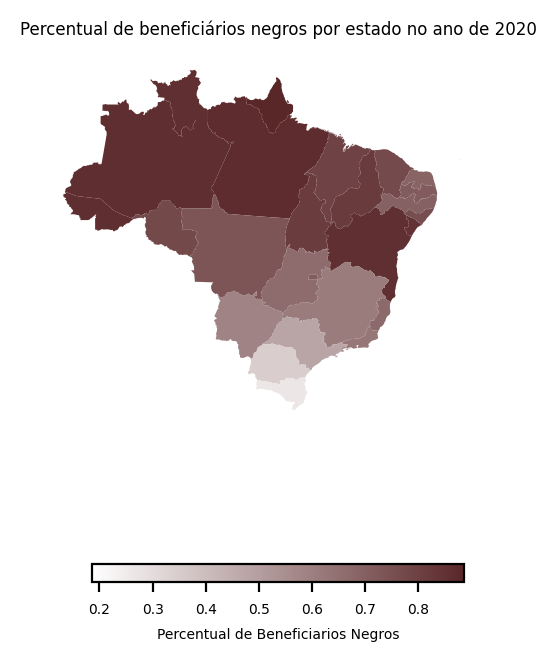

In [11]:
# Aqui, os dados são apresentados de forma bem visual: o gradiente de cor indica um aumento no percentual por estado

plt.rcParams.update({"font.size": 5})
fig, ax = plt.subplots(figsize=(4, 4), dpi=200)

dados.plot(
    column="PERCENTUAL_NEGROS",
    cmap=newcmp,
    legend=True,
    legend_kwds={
        "label": "Percentual de Beneficiarios Negros",
        "orientation": "horizontal",
        "shrink": 0.6,
    },
    ax=ax,
)

ax.set_title("Percentual de beneficiários negros por estado no ano de 2020")
ax.axis("off")


/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


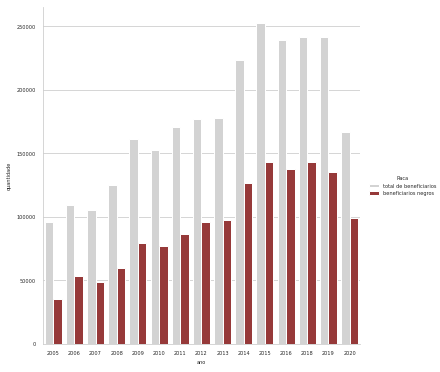

In [12]:
# Aqui a ideia é apresentar os dados históricos dos beneficiários num gráfico de barras pra vermos a evolução do número
# total e do percentual racial

plot_df = pd.DataFrame({'ano': year_index,
                        'total de beneficiarios': total,
                       'beneficiarios negros':preta_pard,
                        })
plot_df.index = year_index

df = pd.melt(plot_df, id_vars='ano', var_name="Raca", value_name="quantidade")
sns.set_style("whitegrid")
sns.factorplot(x='ano', y='quantidade', hue='Raca', data=df, kind='bar', palette=["lightgray", "brown"])

